# Exploratory Data Analysis

The goal is to predict SalePrice

In [2]:
KAGGLE=False # set to True if using the Kaggle version of the dataset

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import sklearn.preprocessing

from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold,KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import catboost as cb

from xgboost import XGBRegressor
import pickle


In [4]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

The data has been pre-processed

In [5]:
def load_data(tree=None):
    if KAGGLE:
        train = pd.read_csv('data/train.csv')
        test = pd.read_csv('data/test.csv')
        num_train=np.shape(train)[0]
        num_test=np.shape(test)[0]
        alldata=train.append(test, ignore_index=True)
    else:
        alldata=pd.read_csv('./data/Ames_HousePriceLocs.csv')#, index_col=0) #already cleaned (see work in appendix files)
    return alldata

alldata=load_data()

If working with the Kaggle version of the dataset, can use the function below to do train-test split

In [6]:
#cats = [f for f in alldata.columns if alldata.dtypes[f] == 'object']

In [7]:
#cat_idxs=[]

In [8]:
def label_encode():
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    for column_name in alldata.columns:
        if alldata[column_name].dtype == object:
            #cat_idxs.append(alldata.columns.get_loc(column_name))
            #alldata[column_name] = alldata[column_name].astype(str)
            alldata[column_name] = le.fit_transform(alldata[column_name])
label_encode()

In [9]:
def split_into_train_test(alldata):
    y=alldata['SalePrice']
    X=alldata.drop(['SalePrice'],axis=1)
    from sklearn.model_selection import train_test_split
    if KAGGLE:
        return split_train_test(alldata=alldata,num_train=num_train)
    else:
        return train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = split_into_train_test(alldata)  

The sale price appears to be skewed to the right

# Catboost

In [10]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)


#It would have been desirable to let CatBoost choose how to encode the catecorical columns
#Due to TypeError: Cannot convert 'b'RM'' to float
#I chose to LabelEncode beforehand

# train_dataset = cb.Pool(X_train, y_train,cat_features=cat_idxs) 
# test_dataset = cb.Pool(X_test, y_test,cat_features=cat_idxs)

In [11]:
model_cb = cb.CatBoostRegressor(loss_function='RMSE',verbose=False)

In [12]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8, 10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model_cb.grid_search(grid, train_dataset,verbose=False)


bestTest = 33063.25712
bestIteration = 99


bestTest = 23100.62333
bestIteration = 99


bestTest = 33063.22624
bestIteration = 99


bestTest = 22312.01523
bestIteration = 99


bestTest = 33400.44201
bestIteration = 99


bestTest = 22729.35559
bestIteration = 99


bestTest = 33963.19158
bestIteration = 99


bestTest = 22876.32499
bestIteration = 99


bestTest = 26978.37585
bestIteration = 149


bestTest = 21923.82555
bestIteration = 146


bestTest = 27093.93837
bestIteration = 149


bestTest = 21375.60857
bestIteration = 149


bestTest = 27209.66209
bestIteration = 149


bestTest = 21566.81735
bestIteration = 149


bestTest = 27558.23344
bestIteration = 149


bestTest = 21405.13366
bestIteration = 149


bestTest = 24780.34282
bestIteration = 199


bestTest = 21318.1413
bestIteration = 198


bestTest = 24745.41195
bestIteration = 199


bestTest = 20463.93169
bestIteration = 199


bestTest = 24856.61105
bestIteration = 199


bestTest = 20878.96842
bestIteration = 198


bestTest = 25400.1

{'params': {'depth': 4,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [13]:
from sklearn.metrics import r2_score

pred = model_cb.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

#With lats/longs data, R2 went up from .93 to .95!!!

Testing performance
RMSE: 18656.63
R2: 0.95


In [14]:
sorted_feature_importance = model_cb.feature_importances_.argsort()

Text(0.5, 0, 'CatBoost Feature Importance')

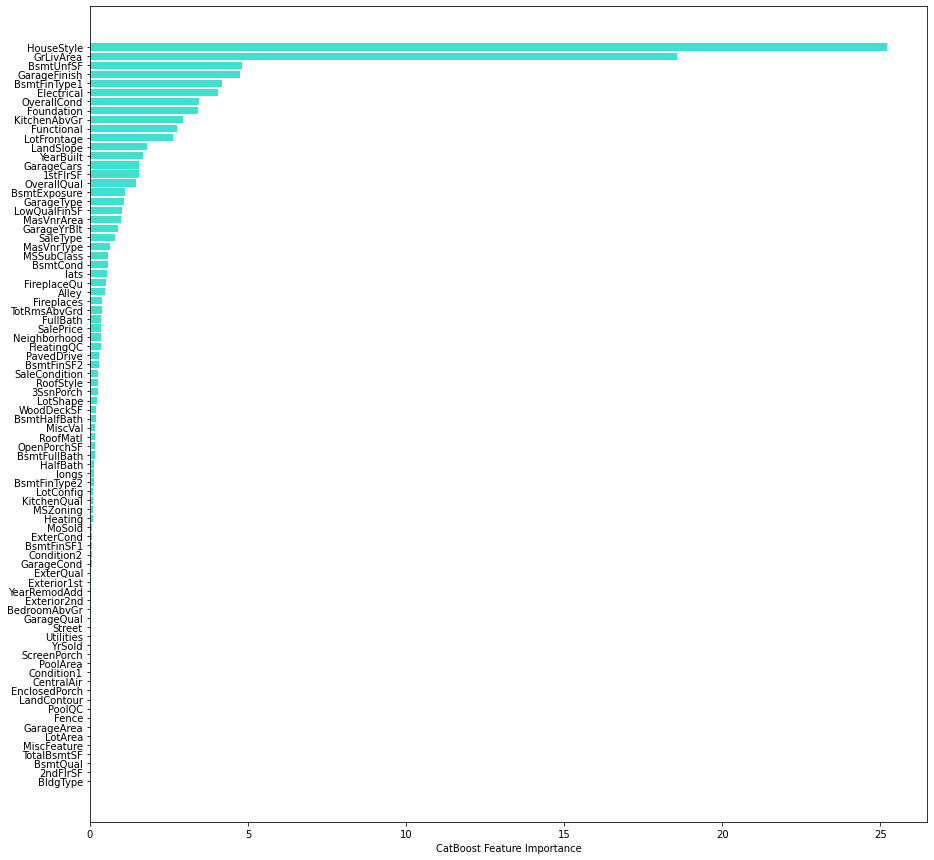

In [15]:
plt.rcParams["figure.figsize"] = (15, 15)

plt.barh(alldata.columns[sorted_feature_importance], 
        model_cb.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [16]:
importances = {}
importances['y'] = pd.Series(model_cb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      25.217012
GrLivArea        18.571059
TotalBsmtSF       4.801403
GarageCars        4.754334
BsmtFinSF1        4.192528
1stFlrSF          4.040365
YearBuilt         3.452576
BsmtQual          3.424553
KitchenQual       2.935115
Fireplaces        2.763501
LotArea           2.615309
Neighborhood      1.811047
YearRemodAdd      1.665398
GarageArea        1.542326
2ndFlrSF          1.539417
OverallCond       1.461214
BsmtFinType1      1.102321
GarageYrBlt       1.076970
BsmtFullBath      1.008284
ExterQual         0.974552
GarageFinish      0.876493
SaleCondition     0.777935
MasVnrArea        0.645008
MSZoning          0.577348
BsmtExposure      0.561821
longs             0.531219
GarageType        0.492827
LotShape          0.468183
FireplaceQu       0.396012
Functional        0.376647
HalfBath          0.364507
MSSubClass        0.350029
Condition1        0.347664
CentralAir        0.345384
WoodDeckSF        0.298305
BsmtUnfSF         0.284223
lats              0.267934
R

In [17]:
import shap

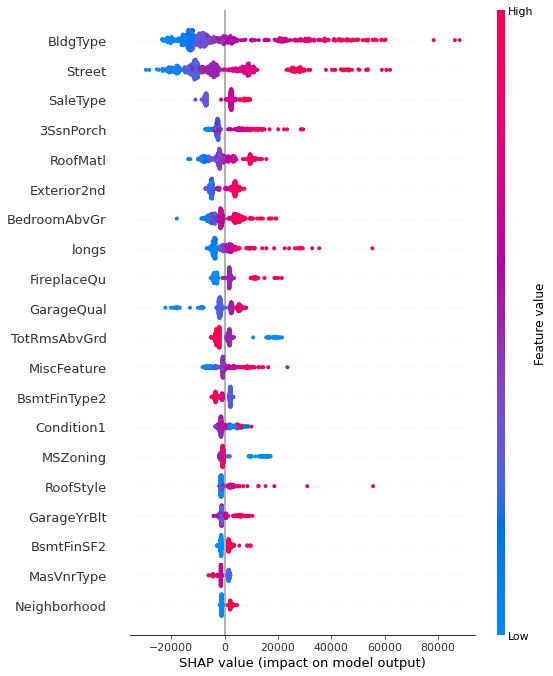

In [18]:
explainer = shap.TreeExplainer(model_cb)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

In [99]:
#shap.plots.waterfall??

In [102]:
# explainer = shap.Explainer(model_cb, X_test)
# shap_values = explainer(X_test)
# shap.plots.waterfall(shap_values[0])

In [20]:
model_cb.save_model('./models/model_cb_locs2')

In [29]:
# import pickle
# pickle.dump(model_cb, open('./models/model_cb_locs', 'wb'))

#loaded_cb = pickle.load(open('model_cb', 'rb'))

# RF

In [22]:
class TrainTree:
    def __init__(self,X_train, X_test, y_train, y_test,model,grid):
        self.model=model
        self.grid=grid
        self.X_train, self.X_test, self.y_train, self.y_test=X_train, X_test, y_train, y_test
 
    def run_tree(self):    
        cv=KFold(n_splits=5, random_state=42, shuffle=True)
        gsCV = GridSearchCV(cv=cv,
                     estimator=self.model,
                     n_jobs=2,
                     param_grid=self.grid,
                     return_train_score=True,
                     verbose=4)

        %time obj = gsCV.fit(self.X_train, self.y_train)

        preds = gsCV.predict(self.X_test)
        kf = KFold(n_splits=12, random_state=42, shuffle=True)
        rmse_cv = np.sqrt(-cross_val_score(self.model, self.X_train, self.y_train, scoring="neg_mean_squared_error", cv=cv))

        rmse = np.sqrt(mean_squared_error(self.y_test,preds))
        print(f'RMSE on Test: {rmse}')
        print(f'RMSE from CV: {rmse_cv.mean()}')
        return gsCV

In [108]:
#TRAINED AFTER MODIFYING CLASS
# grid_rf={'n_estimators':range(100,200,100), 'min_samples_leaf':range(10,20,10)}



# rf_=TrainTree(X_train, X_test, y_train, y_test,
#             RandomForestRegressor(random_state=42, verbose=1),
#             grid = grid_rf)
# results=rf_.run_tree()

In [109]:
# grid_rf={'n_estimators':range(700,1200,100)}

# rf_=TrainTree(alldata,
#             RandomForestRegressor(random_state=42, verbose=1,min_samples_leaf=10,max_depth=15),
#             grid = grid_rf)
# model_rf=rf_.run_tree()


In [110]:
# model_rf=results
# from sklearn.metrics import r2_score

# pred = model_rf.predict(X_test)
# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.2f}'.format(rmse))
# print('R2: {:.2f}'.format(r2))

In [111]:
#Pre-Coords
#model_rf=results
# from sklearn.metrics import r2_score

# pred = model_rf.predict(X_test)
# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.2f}'.format(rmse))
# print('R2: {:.2f}'.format(r2))

In [24]:
def run_model(model,X_train,y_train,X_test,y_test):
    
    # Fit Model
    model.fit(X_train,y_train)
    
    # Get Metrics
    
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    print(f'RMSE : {rmse}')
    r2 = r2_score(y_test, preds)
    print(f'R^2 : {r2}')

    return model

In [25]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
run_model(model_rf,X_train,y_train,X_test,y_test)

RMSE : 23976.644107787837
R^2 : 0.9112507812821278


RandomForestRegressor()

In [26]:
!pwd

/Users/dmitriyapopov/Desktop/BC/Projects/housing-price-predictions


In [30]:
pickle.dump(model_rf, open('./models/model_rf_locs', 'wb'))


In [32]:
importances = {}
importances['y'] = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      5.405162e-01
GrLivArea        1.668374e-01
1stFlrSF         4.471855e-02
TotalBsmtSF      3.899971e-02
BsmtFinSF1       3.117690e-02
GarageArea       1.979020e-02
GarageCars       9.294686e-03
YearBuilt        9.213743e-03
KitchenQual      8.908892e-03
LotArea          8.834306e-03
2ndFlrSF         7.632917e-03
lats             6.584288e-03
GarageFinish     6.417066e-03
longs            5.993607e-03
YearRemodAdd     5.839243e-03
LotFrontage      5.264159e-03
Fireplaces       4.565048e-03
MasVnrArea       4.168605e-03
OpenPorchSF      3.897972e-03
BsmtUnfSF        3.897204e-03
Neighborhood     3.859919e-03
BsmtQual         3.769250e-03
OverallCond      3.628819e-03
GarageYrBlt      3.628776e-03
ExterQual        3.310011e-03
MoSold           3.297726e-03
BsmtFinType1     3.230824e-03
WoodDeckSF       3.015599e-03
TotRmsAbvGrd     2.604828e-03
MSZoning         2.289161e-03
FullBath         2.278812e-03
SaleCondition    1.906796e-03
FireplaceQu      1.672624e-03
MSSubClass

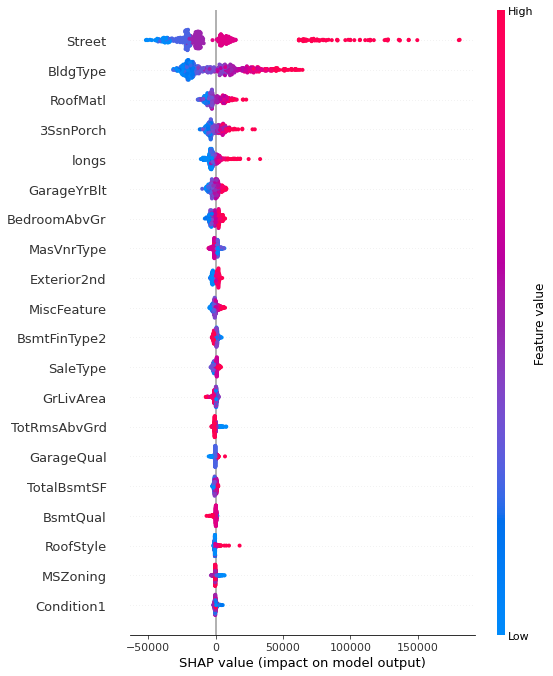

In [33]:
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

In [34]:
# explainer = shap.TreeExplainer(model_rf.best_estimator_)
# shap_values = explainer.shap_values(X_test)
# shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

# XGBoost

In [36]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
grid_xgb={'n_estimators':range(4000,7000,1000)}#, 'max_depth':range(3,6)}
xgboost = XGBRegressor(learning_rate=0.01,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.8,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=42,
                       reg_alpha=0.00006,
                       random_state=42)
xgb_=TrainTree(X_train, X_test, y_train, y_test,
           model=xgboost,
            grid = grid_xgb)
model_xgb=xgb_.run_tree()


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[20:10:12] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 1min 21s, sys: 4.26 s, total: 1min 25s
Wall time: 4min 45s
[20:10:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:43] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[20:10:44] WARNING: /Users/runner

In [38]:
model_xgb.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.6, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=0,
             missing=nan, monotone_constraints='()', n_estimators=5000,
             n_jobs=-1, nthread=-1, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=42, ...)

In [39]:
from sklearn.metrics import r2_score

pred = model_xgb.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 18651.98
R2: 0.95


In [40]:
#Pre lat-long
# from sklearn.metrics import r2_score

# pred = model_xgb.predict(X_test)
# rmse = (np.sqrt(mean_squared_error(y_test, pred)))
# r2 = r2_score(y_test, pred)
# print('Testing performance')
# print('RMSE: {:.2f}'.format(rmse))
# print('R2: {:.2f}'.format(r2))

In [41]:
pickle.dump(model_xgb, open('./models/model_xgb_locs', 'wb'))

#loaded_xgb = pickle.load(open('model_xgb', 'rb'))

In [42]:
importances = {}
importances['y'] = pd.Series(model_xgb.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      0.305711
GarageCars       0.177999
BsmtQual         0.066505
KitchenQual      0.056831
GrLivArea        0.039925
Fireplaces       0.024724
ExterQual        0.022241
YearBuilt        0.021991
TotalBsmtSF      0.019474
CentralAir       0.017773
GarageFinish     0.015088
BsmtFinSF1       0.015037
1stFlrSF         0.014582
GarageType       0.012793
GarageArea       0.012411
FullBath         0.012059
FireplaceQu      0.010531
BsmtFullBath     0.008310
MSZoning         0.007886
RoofMatl         0.007327
YearRemodAdd     0.007290
OverallCond      0.006962
BsmtFinType1     0.006539
2ndFlrSF         0.006525
SaleCondition    0.005132
BsmtExposure     0.004578
HalfBath         0.004365
MissingLoc       0.004288
LotArea          0.004204
Functional       0.004069
Neighborhood     0.003545
ScreenPorch      0.003517
BldgType         0.003455
LandContour      0.003111
HeatingQC        0.003047
KitchenAbvGr     0.002969
GarageYrBlt      0.002623
TotRmsAbvGrd     0.002569
SaleType    

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


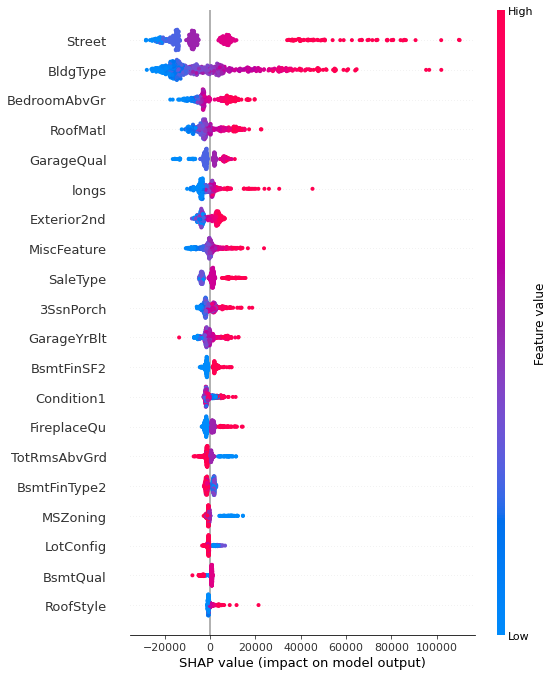

In [43]:
explainer = shap.TreeExplainer(model_xgb.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = alldata.columns[sorted_feature_importance])

# Compare a few different models below to get an idea of relative performance

## np.sqrt(mean_squared_error(y_test,rf_preds))

In [74]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
run_model(model_lr,X_train,y_train,X_test,y_test)

RMSE : 25385.31006861012
R^2 : 0.9005161258306823


LinearRegression()

In [75]:
from sklearn.ensemble import RandomForestRegressor
model_rf = RandomForestRegressor()
run_model(model_rf,X_train,y_train,X_test,y_test)

RMSE : 25144.762988612016
R^2 : 0.9023925791293337


RandomForestRegressor()

In [78]:
importances = {}
importances['y'] = pd.Series(model_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importances['y']

OverallQual      5.815197e-01
1stFlrSF         5.826681e-02
FullBath         4.307005e-02
GarageArea       3.900812e-02
2ndFlrSF         3.135091e-02
TotalBsmtSF      3.122583e-02
BsmtFinSF1       2.986800e-02
LotArea          2.209708e-02
GarageCars       1.344276e-02
Fireplaces       1.027501e-02
lats             9.364675e-03
MasVnrArea       7.342814e-03
LotFrontage      7.166977e-03
KitchenQual      6.982249e-03
TotRmsAbvGrd     6.667535e-03
BsmtQual         6.324967e-03
YearBuilt        6.177922e-03
YearRemodAdd     6.138475e-03
longs            5.294645e-03
Neighborhood     5.201677e-03
WoodDeckSF       5.169345e-03
OpenPorchSF      4.986943e-03
BsmtUnfSF        4.616367e-03
MoSold           4.047977e-03
OverallCond      3.496752e-03
GarageYrBlt      3.405651e-03
GarageType       2.976310e-03
FireplaceQu      2.478084e-03
ExterQual        2.418700e-03
BedroomAbvGr     2.349930e-03
MSSubClass       2.022964e-03
BsmtFullBath     1.953859e-03
BsmtFinType1     1.784642e-03
Exterior1s

In [76]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

model_gb = GradientBoostingRegressor()
run_model(model_gb,X_train,y_train,X_test,y_test)

RMSE : 21649.56045272719
R^2 : 0.9276421071228171


GradientBoostingRegressor()

In [77]:
from sklearn.ensemble import AdaBoostRegressor
model_ab = AdaBoostRegressor()
run_model(model_ab,X_train,y_train,X_test,y_test)

RMSE : 34856.118423080276
R^2 : 0.8124375964332984


AdaBoostRegressor()

In [42]:
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.01,0.1,1,5,10,100,1000],'gamma':['auto','scale']}  #Are gammas for variance?
svr = SVR()
grid = GridSearchCV(svr,param_grid)
run_model(grid,X_train,y_train,X_test,y_test)



RMSE : 80957.62904185217


In [39]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

std_scale = StandardScaler()
s = std_scale.fit_transform(X_train)
pca = PCA(n_components=30)

pca.fit(X_train)
pc = pca.transform(s)
model_kmeans = KMeans(n_clusters=5)

run_model(model_kmeans,X_train,y_train,X_test,y_test)


RMSE : 199030.80108212752


/usr/local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [35]:
from sklearn.neighbors import KNeighborsRegressor
k_values = [1,5,10,50]

for n in k_values:
    model = KNeighborsRegressor(n_neighbors=n)
    run_model(model,X_train,y_train,X_test,y_test)

RMSE : 45896.06127854242
RMSE : 44574.96970627604
RMSE : 48929.23713010485
RMSE : 57164.68533098934


In [44]:
# from sklearn.pipeline import make_pipeline 
# from sklearn.preprocessing import PolynomialFeatures, StandardScaler
# pipe = make_pipeline(OneHotEncoder(),StandardScaler(),PolynomialFeatures(3),LinearRegression())
# run_model(pipe,X_train,y_train,X_test,y_test)